# Let's dive deeper (without killing the planet) !
(Widely inspired from https://keras.io/guides/transfer_learning/)

In this tutorial, we experiment an end-to-end transfer learning application for a classification task. We have seen in the lecture that transfer learning is especially interesting when our dataset is small. We can this way benefit from the features learned on a similar problem that has a bigger dataset.

Our goal is to learn a "cats vs dogs" classifier, given a very small dataset composed of 500 images of each for training and 200 for validation. (If you have not already downloaded the data, you can find them here: https://filesender.renater.fr/?s=download&token=9ab7438d-f148-40a7-9eb2-211d92dda46a
Then unzip the file in ./data/)

We will first train a baseline network from scratch. Then, we will use transfer learning by loading a very deep architecture, a ResNet18, that has been pretrained on the ImageNet dataset that contains millions of images. More specifically, we will use the convolutional part of the ResNet as a feature extractor, and train a single fully connected layer as classifier. The transfer learning workflow is then:
1. Load the pretrained version of the model
2. Freeze the weights of the model to keep the information they have learned on ImageNet
3. Replace the original last FC layer with a one (or more) adapted to our problem
4. Train this(ese) new layer(s) on our very small dataset

## Prepare the environment

In [ ]:
import os
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision.datasets.folder import pil_loader
from torchvision.models import resnet18


import pytorch_lightning as pl

import torchvision
from torchvision import transforms

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define computing device
use_cuda = True

if torch.cuda.is_available and use_cuda:
    print('We have GPU !')
    gpu = 1
else:
    print('We will use CPU')
    gpu = 0

In [ ]:
# Fix random seed for reproducibility
pl.trainer.seed_everything(0)

In [ ]:
student_name = ?

## Collect and prepare the data

As "Cats vs Dogs" is not a standard torchvision dataset, we have to create our own custom dataset class. 

The train and test images are in separated folders. Besides, the class of each image is included in its name.

In [ ]:
for directory, folders, files in os.walk('./data/cats_dogs_light/'):
    print(directory)
    print(folders)
    print(files[:6])

We can therefore use the same class to load the train dataset object and the test dataset object.

The custom dataset class inherits from torch.utils.data.Dataset, and has 3 mandatory methods: \_\_init\_\_, \_\_len\_\_ and \_\_getitem\_\_

* In \_\_init\_\_ we need to fetch the data folder (train or test) to list the images.

* \_\_len\_\_ returns the length of the dataset

* \_\_getitem\_\_ returns one sample (one image and its label)

In [ ]:
def get_image_list(path):
    image_list = set([file for file in os.listdir(path) if os.path.isfile(os.path.join(path, file))])
    return list(image_list)

In [ ]:
class CatsDogsDataset(Dataset):

    def __init__(self, data_path='cats_dogs_light/train', transform=None):
        self.data_path = data_path
        self.transform = transform
        self.classes = {'cat': 0, 'dog': 1}
        self.data_list = get_image_list(data_path)
    
    def __len__(self):
        return len(self.data_list)
    
    def __getitem__(self, idx):
        img_name = self.data_list[idx]
        image = pil_loader(os.path.join(self.data_path, img_name))
        label = self.classes[img_name.split('.')[0]]
        
        if self.transform is not None:
            image = self.transform(image)
        
        return image, label        
        

In [ ]:
class CatsDogsDataModule(pl.LightningDataModule):

    def __init__(
        self,
        batch_size: int = 8,
    ):
        super().__init__()
        
        self.batch_size = batch_size
        self.classes = ('cat', 'dog')
        
        train_transform = transforms.Compose([
            # We use data augmentation for training
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(0.1),
            # We will use a model pretrained on Imagenet, we have to resize images
            transforms.Resize(224),
#             transforms.RandomCrop(224),
            transforms.CenterCrop(224),
            
            transforms.ToTensor(),
            # and to apply the correct normalization
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        val_transform = transforms.Compose([
            # For validation, we only resize images
            transforms.Resize(224),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            # and apply the correct normalization
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])])
        
        self.train_set = CatsDogsDataset(data_path='./data/cats_dogs_light/train', transform=train_transform)
        self.test_set = CatsDogsDataset(data_path='./data/cats_dogs_light/test', transform=val_transform)

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, 
                          num_workers=4, pin_memory=True, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.test_set, batch_size=self.batch_size, 
                          num_workers=4, pin_memory=True)


### Let's visualize some images

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(12, 4))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [ ]:
data_module = CatsDogsDataModule()
# Get a batch of training data
inputs, classes = next(iter(data_module.val_dataloader()))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[data_module.classes[x] for x in classes])

# Exercises
1. Implement and train our VGG like architecture (from tutorial 4) as a baseline. Play a bit with the learning rate. Can you improve the performance of the model ?
2. Load a pretrained ResNet18 model. Freeze its weights, replace the last fully connected layer to match the classification case "Cats vs Dogs".
3. Train the modified ResNet18. How does the performance improve compared to the baseline ? What is the impact of transfer learning on the number of trainable parameters and on the training time ?

## 1. Implement and train a neural network baseline from scratch
As a baseline to evaluate the improvement brought by transfer learning, we implement and train the same VGG like architecture as in T4.

In [ ]:
class BaselineClassifier(pl.LightningModule):

    def __init__(
        self,
        learning_rate: float = 0.0001,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        
        self.model = ?
        
        self.accuracy = Accuracy()
        
    def forward(self, x):
        # use forward for inference/predictions
        x = self.model(x)
        x = F.softmax(x, dim=1)  # Transform network outputs into probabilities       
        return x

    def training_step(self, batch, batch_idx):
        # Function called by Lightning for each iteration
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('Loss', {'train_loss': loss}, on_step=False, on_epoch=True)
        self.log('Accuracy', {'train_accuracy': acc}, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('Loss', {'val_loss': loss}, loss)
        self.log('Accuracy', {'val_accuracy': acc}, acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        return [optimizer]


In [ ]:
learning_rate = 0.001
batch_size = 32
max_epochs = 55

In [ ]:
data_module = CatsDogsDataModule(batch_size=batch_size)
net_baseline = BaselineClassifier(learning_rate=learning_rate)

In [ ]:
trainer = pl.Trainer(default_root_dir='./lightning_logs/T5_baseline_' + student_name, gpus=gpu, max_epochs=max_epochs)

In [ ]:
# Let Lightning train the network
trainer.fit(net_baseline, data_module)

### Let us check the prediction on some test images

In [ ]:
# get some random training images
n_img = 8
dataiter = iter(data_module.val_dataloader())
images, labels = dataiter.next()
with torch.no_grad():
    predictions = net_baseline(images)
predicted_labels = torch.argmax(predictions, dim=1)

# show images
imshow(torchvision.utils.make_grid(images[:n_img]))
# print labels
print('Predictions')
print(' '.join('%5s' % data_module.classes[pred_lab] for pred_lab in predicted_labels[:n_img]))
print('True classes')
print(' '.join('%5s' % data_module.classes[true_lab] for true_lab in labels[:n_img]))

## 2. Load a pretrained ResNet18
For transfer learning, we use a ResNet like model of 18 layers called ResNet18. See https://arxiv.org/pdf/1512.03385.pdf for details.

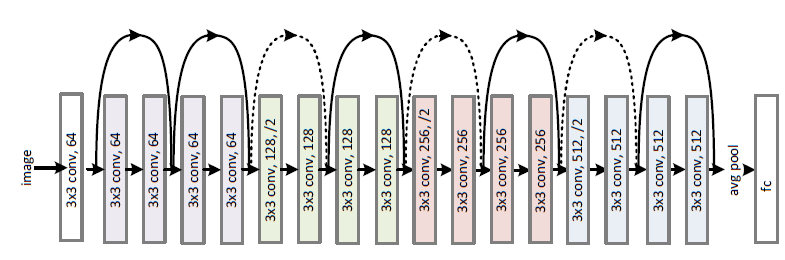


ResNets are very deep architectures whose specificity lies in their residual blocks. A skip connection that add the input of a block to its output, allows the gradient flowing in the model despite the network depth.

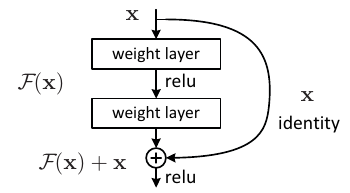


### Some hints on model exploration

#### How to load a pretrained model

In [ ]:
model = resnet18(pretrained=True)

In [ ]:
model

#### How to access layers

In [ ]:
for name, child in model.named_children():
    print(name)

In [ ]:
for name, modules in model.named_modules():
    print(name)

In [ ]:
for name, param in model.named_parameters():
    print(name, param.requires_grad)

#### How to modify a specific layer

In [ ]:
model.relu = torch.nn.LeakyReLU()

In [ ]:
model

#### How to modify gradient retaining information

In [ ]:
model.layer1[0].conv1.weight.requires_grad

In [ ]:
model.layer1[0].conv1.weight.requires_grad = False

In [ ]:
model.layer1[0].conv1.weight.requires_grad

### ResNet18 module

In [ ]:
class ResNet18PreTrainedClassifier(pl.LightningModule):

    def __init__(
        self,
        learning_rate: float = 0.0001,
    ):
        super().__init__()
        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.model = ?
        # We first freeze the convolutional part of the network
        ?
        # We replace the final fully connected layer to match our case
        # Only this layer will be trained
        ?
        
        
        self.accuracy = Accuracy()
        
    def forward(self, x):
        # use forward for inference/predictions
        x = self.model(x)
        x = F.softmax(x, dim=1)  # Transform network outputs into probabilities       
        return x

    def training_step(self, batch, batch_idx):
        # Function called by Lightning for each iteration
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('Loss', {'train_loss': loss}, on_step=False, on_epoch=True)
        self.log('Accuracy', {'train_accuracy': acc}, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('Loss', {'val_loss': loss}, loss)
        self.log('Accuracy', {'val_accuracy': acc}, acc)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)  # Includes a LogSoftmax and the NegativeLogLikelihood loss
        acc = self.accuracy(F.softmax(y_hat, dim=1), y)
        self.log('test_loss', loss)
        self.log('test_accuracy', acc)

    def configure_optimizers(self):
        # self.hparams available because we called self.save_hyperparameters()
        optimizer = torch.optim.SGD(self.parameters(), lr=self.hparams.learning_rate, momentum=0.9)
        return [optimizer]


In [ ]:
learning_rate = 0.001
batch_size = 32
max_epochs = 30

In [ ]:
data_module = CatsDogsDataModule(batch_size=batch_size)
net_module = ResNet18PreTrainedClassifier(learning_rate=learning_rate)

In [ ]:
# Let's check that only the last fully connected layer will retain gradient information
for name, param in net_module.model.named_parameters():
    print(name, param.requires_grad)

In [ ]:
trainer = pl.Trainer(default_root_dir='./lightning_logs/T5_resnet18_' + student_name, gpus=gpu, max_epochs=max_epochs)

# Log network graph to Tensorboard
trainer.logger.experiment.add_graph(net_module, torch.rand(batch_size, 3, 32, 32))

In [ ]:
# Let Lightning train the network
trainer.fit(net_module, data_module)

### Let us check the prediction on some test images

In [ ]:
# get some random training images
n_img = 8
dataiter = iter(data_module.val_dataloader())
images, labels = dataiter.next()
with torch.no_grad():
    predictions = net_module(images)
predicted_labels = torch.argmax(predictions, dim=1)

# show images
imshow(torchvision.utils.make_grid(images[:n_img]))
# print labels
print('Predictions')
print(' '.join('%5s' % data_module.classes[pred_lab] for pred_lab in predicted_labels[:n_img]))
print('True classes')
print(' '.join('%5s' % data_module.classes[true_lab] for true_lab in labels[:n_img]))

## Do you need a "solution" ?
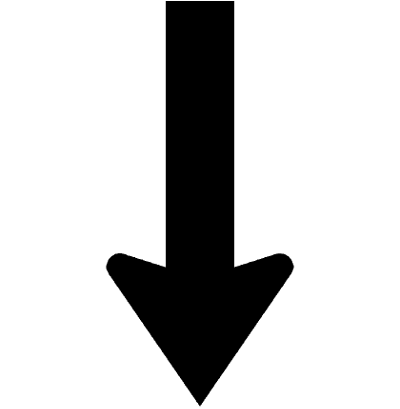

## Baseline

### Hints

* Beware of the number of output_features of the last FC layer.

### Solution

In [ ]:
# VGG like network
self.model = torch.nn.Sequential(  
            torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            torch.nn.Flatten(),
            torch.nn.Linear(in_features=64, out_features=2)
        )

## Pretrained ResNet18

### Hints

* You can use model.parameters() to access the requires_grad information in a for loop
* Beware of the number of input_features and output_features of the last FC layer

### Solution

In [ ]:
self.model = resnet18(pretrained=True)
# We first freeze the convolutional part of the network
for param in self.model.parameters():
    param.requires_grad = False
# We replace the final fully connected layer to match our case
# Only this layer will be trained
num_ftrs = self.model.fc.in_features
self.model.fc = torch.nn.Linear(in_features=num_ftrs, out_features=2)